# The problem
Given information about a client who bought an audio book, try to predict if he is likely to buy another.

### The Data
A CSV file where each row contains the following data about a client:
- Customer ID
- Total books length (minutes)
- Average books length (minutes)
- Total book price
- Average book price
- Total review
- Review on a 10/10 scale
- Minutes listened
- Completion (0-1)
- Support requests
- Last visit since last purchase date
- Targets

This data was collected during a 2 year period and the 'Targets' column represents if a person bought another book again 6 months after the 2 year data collection period.

## First look at the data

In [1]:
# Import relevant libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing

In [2]:
# Load the data
raw_data = pd.read_csv('Audiobooks_data.csv', header=None)
raw_data = raw_data.iloc[:, 1:]
raw_data.head()

,1,2,3,4,5,6,7,8,9,10,11
0,1620.0,1620,19.73,19.73,1,10.00,0.99,1603.8,5,92,0
1,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,0,0
2,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,388,0
3,1620.0,1620,5.96,5.96,0,8.91,0.42,680.4,1,129,0
4,2160.0,2160,5.33,5.33,0,8.91,0.22,475.2,0,361,0


### Dataset balance
After looking at the data using the 'Data Wrangler' extension I see that the dataset is unbalanced as the number of clients that didn't buy a book again largely outweigh the ones that did.  
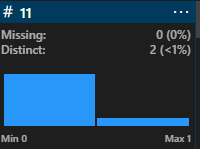
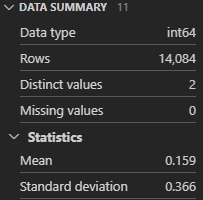

In [3]:
# Balance the dataset

# Get total number of ones
n_ones = raw_data.iloc[:, -1].value_counts()[1]

# Get all that have 'target' equal to 0
target_zero = raw_data.loc[raw_data.iloc[:, -1] == 0]

# Take random sample
random_target_zero = target_zero.sample(n_ones)

# Merge the balanced targets 0 and 1
balanced_data = pd.concat([raw_data.loc[raw_data.iloc[:, -1] == 1], random_target_zero])

# Shuffle data since currently the first half has 'targets' 1's and the second has 0's
balanced_data = balanced_data.sample(frac=1)
balanced_data.head()

,1,2,3,4,5,6,7,8,9,10,11
2183,1188.0,1188,5.33,5.33,0,8.91,0.00,0.0,0,152,1
715,2160.0,2160,8.00,8.00,0,8.91,0.03,64.8,0,290,0
4195,1620.0,1620,6.40,6.40,0,8.91,0.19,307.8,0,4,0
10141,1620.0,1620,5.33,5.33,0,8.91,0.01,16.2,0,64,0
410,2160.0,2160,10.13,10.13,0,8.91,0.00,0.0,0,33,1


As we can see the targets are balanced now  
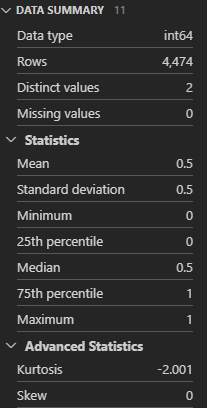
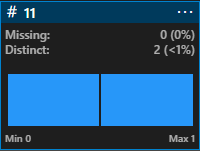

### Input scaling

In [4]:
scaled_data = balanced_data.copy()
scaled_data.iloc[:, :-1] = preprocessing.scale(balanced_data.iloc[:, :-1])
scaled_data.head()

,1,2,3,4,5,6,7,8,9,10,11
2183,-0.737089,-0.734640,-0.364003,-0.481726,-0.432495,-0.000255,-0.371726,-0.366259,-0.187017,0.885869,1
715,1.208488,0.375634,0.165037,-0.082558,-0.432495,-0.000255,-0.216349,-0.146025,-0.187017,2.372787,0
4195,0.127612,-0.241185,-0.151990,-0.321760,-0.432495,-0.000255,0.612328,0.679854,-0.187017,-0.708796,0
10141,0.127612,-0.241185,-0.364003,-0.481726,-0.432495,-0.000255,-0.319934,-0.311200,-0.187017,-0.062310,0
410,1.208488,0.375634,0.587081,0.235879,-0.432495,-0.000255,-0.371726,-0.366259,-0.187017,-0.396328,1


### Split the dataset
We'll need training, validation and testing (no need to shuffle I already did that)

In [5]:
# Will use a 80-10-10 split
n_samples = scaled_data.shape[0]

train_samples = int(0.8 * n_samples)
validation_samples = int(0.1 * n_samples)

# Turn DF to Numpy to make process easier
data = scaled_data.to_numpy()

# Train
train_data = data[:train_samples]
train_inputs = train_data[:, :-1]
train_targets = train_data[:, -1]

# Validate
validation_data = data[train_samples:train_samples+validation_samples]
validation_inputs = validation_data[:, :-1]
validation_targets = validation_data[:, -1]

# Test
test_data = data[train_samples+validation_samples:]
test_inputs = test_data[:, :-1]
test_targets = test_data[:, -1]


### Save dataset

In [6]:
np.savez('Audiobooks_training', inputs=train_inputs, targets=train_targets)
np.savez('Audiobooks_validation', inputs=validation_inputs, targets=validation_targets)
np.savez('Audiobooks_testing', inputs=test_inputs, targets=test_targets)

## Open data

In [7]:
npz = np.load('Audiobooks_training.npz')

train_inputs = npz['inputs'].astype(float)
train_targets = npz['targets'].astype(int)

npz = np.load('Audiobooks_validation.npz')

validation_inputs= npz['inputs'].astype(float)
validation_targets = npz['targets'].astype(int)

## Model

Outline

In [8]:
input_sz = 10
output_sz = 2
hidden_layer_sz = 50

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_sz, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_sz, activation='relu'),
    tf.keras.layers.Dense(output_sz, activation='softmax')
])

Loss function and optimizer

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Training

In [10]:
# Separate into batches to use Mini-batch Gradient Descent
BATCH_SZ = 100
N_EPOCHS = 100

model.fit(
    train_inputs, 
    train_targets, 
    batch_size=BATCH_SZ, 
    epochs=N_EPOCHS, 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)], 
    validation_data=(validation_inputs, validation_targets), 
    verbose=1
)

Epoch 1/100


36/36 [==============================] - 3s 16ms/step - loss: 0.5991 - accuracy: 0.6583 - val_loss: 0.5304 - val_accuracy: 0.7293
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 0.4793 - accuracy: 0.7787 - val_loss: 0.4642 - val_accuracy: 0.7450
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.4283 - accuracy: 0.7902 - val_loss: 0.4345 - val_accuracy: 0.7696
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.4045 - accuracy: 0.7955 - val_loss: 0.4325 - val_accuracy: 0.7494
Epoch 5/100
36/36 [==============================] - 0s 5ms/step - loss: 0.3918 - accuracy: 0.7921 - val_loss: 0.4117 - val_accuracy: 0.7718
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.3798 - accuracy: 0.8075 - val_loss: 0.4021 - val_accuracy: 0.7808
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.3729 - accuracy: 0.8050 - val_loss: 0.4105 - val_accuracy: 0.7539
Epoch 8/100
36/36 [=====

### Testing

In [11]:
npz = np.load('Audiobooks_testing.npz')

test_inputs = npz['inputs'].astype(float)
test_targets = npz['targets'].astype(int)

test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

print(f'Test loss: {test_loss:.2f}\nTest accuracy: {test_accuracy*100:.2f}%')

14/14 [==============================] - 0s 6ms/step - loss: 0.3676 - accuracy: 0.8103
Test loss: 0.37
Test accuracy: 81.03%
